In [1]:
!pip install google-play-scraper transformers pandas seaborn matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00


In [2]:
from google_play_scraper import reviews

results, _ = reviews(
    'com.saver.photoandvideosaver',  # Replace with your app
    lang='en',
    count=500
)

import pandas as pd
df = pd.DataFrame(results)[['content']]
df.columns = ['review']


In [3]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['cleaned'] = df['review'].apply(clean_text)


In [4]:
from transformers import pipeline

sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
df['sentiment'] = df['cleaned'].apply(lambda x: sentiment_model(x)[0]['label'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [5]:
def tag_user_behavior_multi(text):
    text = text.lower()
    return {
        'Loyal Use': int("years" in text or "long time" in text),
        'Churn Threat': int("uninstall" in text or "switching" in text),
        'Frustration': int("crash" in text or "freeze" in text),
        'Exploration': int("just tried" in text or "installed today" in text),
        'Feature Seeking': int("please add" in text or "feature request" in text),
        'Help Request': int("help" in text or "how to" in text),
        'Comparative': int("better than" in text or "worse than" in text),
        'Trust/Ethics': int("privacy" in text or "permission" in text)
    }

In [6]:
behavior_df = df['review'].apply(tag_user_behavior_multi).apply(pd.Series)

In [7]:
df = pd.concat([df, behavior_df], axis=1)

In [8]:
print(df.columns)  # Should include 'behavior_tag'


Index(['review', 'cleaned', 'sentiment', 'Loyal Use', 'Churn Threat',
       'Frustration', 'Exploration', 'Feature Seeking', 'Help Request',
       'Comparative', 'Trust/Ethics'],
      dtype='object')


In [9]:
def get_main_behavior(row):
    for col in ['Loyal Use', 'Churn Threat', 'Frustration', 'Exploration',
                'Feature Seeking', 'Help Request', 'Comparative', 'Trust/Ethics']:
        if row[col] == 1:
            return col
    return None

df['main_behavior'] = df.apply(get_main_behavior, axis=1)


/tmp/ipython-input-1555695847.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='main_behavior', data=df, order=df['main_behavior'].value_counts().index, palette="viridis")


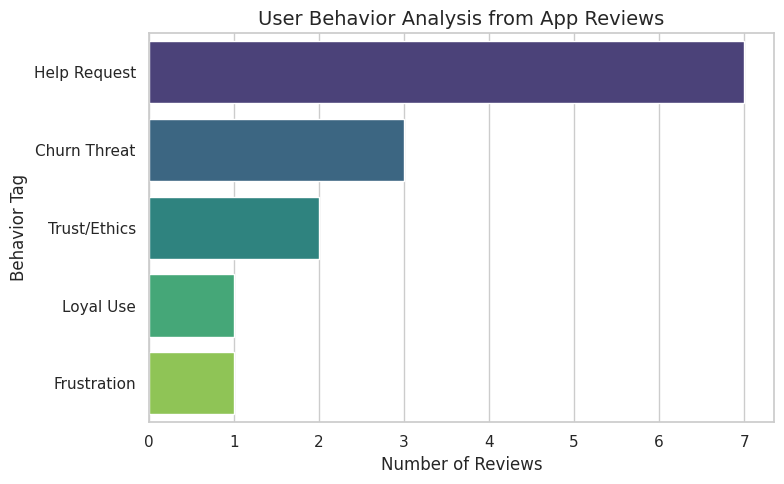

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(y='main_behavior', data=df, order=df['main_behavior'].value_counts().index, palette="viridis")

plt.title("User Behavior Analysis from App Reviews", fontsize=14)
plt.xlabel("Number of Reviews")
plt.ylabel("Behavior Tag")
plt.tight_layout()
plt.show()


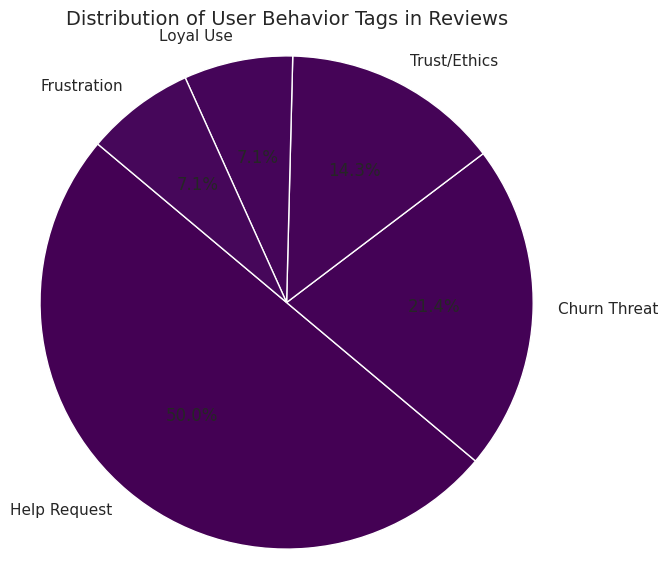

In [11]:
behavior_counts = df['main_behavior'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(behavior_counts, labels=behavior_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.viridis.colors)
plt.title("Distribution of User Behavior Tags in Reviews", fontsize=14)
plt.axis('equal')
plt.show()


In [12]:
print(df.columns)



Index(['review', 'cleaned', 'sentiment', 'Loyal Use', 'Churn Threat',
       'Frustration', 'Exploration', 'Feature Seeking', 'Help Request',
       'Comparative', 'Trust/Ethics', 'main_behavior'],
      dtype='object')
